In [1]:
import os, sys
sys.path.append("/project/ppi_workspace/toil-env36/lib/python3.6/site-packages")
from shutil import copyfileobj

import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import special_ortho_group
from toil.job import Job
from molmimic.common.voxels import ProteinVoxelizer
from molmimic.common.featurizer import ProteinFeaturizer
from molmimic.util.pdb import tidy
import mpl_toolkits.mplot3d.axes3d as p3

In [50]:
def get_structure(pdb_file, ligand=False):
    """Read structure and features (or calculate if not present)"""
    features_path = os.path.dirname(pdb_file)
    try:
        protein = ProteinVoxelizer(
            pdb_file, 
            os.path.splitext(os.path.basename(pdb_file))[0], 
            features_path=features_path,
            ligand=ligand,
            volume=65)
    except FileNotFoundError:
        print("---")
        #Calculate features
        protein = ProteinFeaturizer(
            pdb_file, 
            os.path.splitext(os.path.basename(pdb_file))[0], 
            Job(), 
            os.path.dirname(pdb_file), 
            force_feature_calculation=True)
        print("---")
        
        #Only calculate accesible surface area
        [protein.get_accessible_surface_area_residue(protein._remove_altloc(a)) for a in protein.get_atoms()]
        
        protein.write_features()
        
        #Try reading again
        protein = ProteinVoxelizer(
            pdb_file, 
            os.path.splitext(os.path.basename(pdb_file))[0], 
            features_path=features_path,
            ligand=ligand,
            volume=65)
    
    return protein

In [55]:
def voxelize(protein, ligand=False, plot=True):
    """Rp=−1  on a surface layer and Rp=1 on the core of the receptor,
        Lp=1 on the entire ligand, and Rp=Lp=0 everywhere else. It is clear that
        this scoring function, which is essentially the one used by
        Katchalski-Katzir et al. (5), reaches its minimum on a conformation in
        which the ligand maximally overlaps with the surface layer of the receptor,
        thus providing optimal shape complementarity. https://doi.org/10.1073/pnas.1603929113"""
    indices, data, _, _, _ = protein.map_atoms_to_voxel_space(
        autoencoder=True,
        only_surface=False,
        simple_fft=True)
    volume = np.zeros((65,65,65,1))
    x, y, z = zip(*indices.astype(int).tolist())
    volume[x,y,z] = data
    del indices, data, _
    
    if plot:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.voxels(volume.reshape(65,65,65)!=0, facecolors='g' if ligand else 'b', edgecolor='g' if ligand else 'b')
        plt.show()
    
    volume = torch.from_numpy(volume[None])
    if torch.cuda.is_available():
        volume=volume.cuda()
        
    return volume

In [4]:
def create_rotated_volume(ligand, rvs=None):
    if rvs is None:
        pass

In [63]:
def dock_pair(receptor_file, ligand_file, rotations=100):
    #Read receptor and features (or calculate if not present)
    receptor = get_structure(receptor_file)
        
    #Read ligand and features (or calculate if not present)
    ligand = get_structure(ligand_file, ligand=True)
    
    #Set to standard orientation
    ligand.orient_to_pai()
        
    #Map receptor to voxels
    receptor_volume = voxelize(receptor)
    
    #Create Fourier image of receptor
    receptor_fft = torch.rfft(receptor_volume, 3)
    
   # print(receptor_fft)
    
    #Take the complex conjugate of receptor
    #receptor_fft = receptor_fft.conj()
    receptor_fft[:,1] *= -1
    
    del receptor_volume
    
    best_rot_mat = None
    best_energy = None
    best_translation = None
    
    for i in range(rotations):
        rot_mat = special_ortho_group.rvs(3)
        print(".", end="")
        
        #Rotate ligand
        next(ligand.rotate(rot_mat))
        
        #Map rotated ligand to voxels
        ligand_volume = voxelize(ligand, ligand=True, plot=(i==0))
        
        #Create Fourier image of rotated ligand
        ligand_fft = torch.rfft(ligand_volume, 3)
        
        #Calculate energy using the convolution thm
        energy = torch.irfft(receptor_fft*ligand_fft, 3).cpu()
        
        #print(energy)
        
        del ligand_volume, ligand_fft
        
        low_energy_ = energy.min()
        
        maxval_z, ind_z = torch.min(energy[0], dim=2, keepdim=False)
        maxval_y, ind_y = torch.min(maxval_z, dim=1)
        maxval_x, ind_x = torch.min(maxval_y, dim=0)
        x = ind_x.item()
        y = ind_y[x].item()
        z = ind_z[x, y].item()
        low_energy = energy[0, x, y, z]
            
        if best_energy is None or low_energy<best_energy:
            best_energy = low_energy
            #best_translation = [[i.item() for i in idx[1:4]] for idx in zip(*torch.where(energy==best_energy))]
            best_translation = [x, y, z]
            best_rot_mat = rot_mat
            print("\nBest Energy {} at {}".format(best_energy, best_translation))
        
        del energy
        
        #Reset to standard orientation
        ligand.orient_to_pai()
        
    #Rotate ligand to best orientation
    next(ligand.rotate(best_rot_mat))
        
    complex_file = "{}_predicted_complex.pdb".format(os.path.basename(receptor_file).split("_")[0], i)
        
    ligand.shift_coords(best_translation, from_origin=False)

    header = "Best Energy={}; Best Translation={}; Best Rotation Matrix\n{}".format(best_energy, best_translation, best_rot_mat)

    complex_structure = receptor.save_pdb(file_like=True, header=header, rewind=False)
    complex_pdb = ligand.save_pdb(path=complex_structure, file_like=True)

    with open(complex_file, "w") as complex_pdb:
        copyfileobj(complex_structure, complex_pdb)

    tidy(complex_file, replace=True)
            
    return complex_file, ligand, best_energy, best_translation

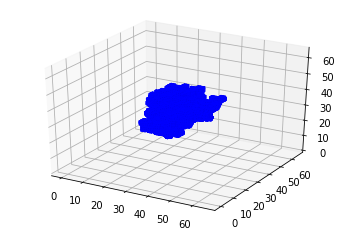

.

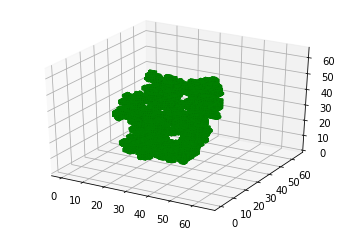


Best Energy tensor([-101.6991], dtype=torch.float64) at [37, 27, 59]
.
Best Energy tensor([-114.5139], dtype=torch.float64) at [45, 35, 63]
..
Best Energy tensor([-116.7033], dtype=torch.float64) at [59, 29, 59]
......
Best Energy tensor([-116.9996], dtype=torch.float64) at [57, 34, 2]
...
Best Energy tensor([-124.1880], dtype=torch.float64) at [57, 31, 61]
................
Best Energy tensor([-131.5202], dtype=torch.float64) at [39, 64, 0]
................................................................
Best Energy tensor([-158.7596], dtype=torch.float64) at [39, 4, 3]
.......

In [64]:
complex_file, ligand, best_energy, best_translation = dock_pair("BM5-clean/HADDOCK-ready/1A2K/1A2K_r_u.pdb", "BM5-clean/HADDOCK-ready/1A2K/1A2K_l_u.pdb")

In [7]:
import pandas as pd

In [8]:
ligand = pd.read_hdf("BM5-clean/HADDOCK-ready/1A2K/1A2K_l_u_atom.h5", "table")

In [9]:
ligand["residue_buried"].isnull().astype(int).sum()

28

In [10]:
pwd

'/sfs/qumulo/qproject/ppi_workspace/notbooks/fft-ppi/SignalsProject'

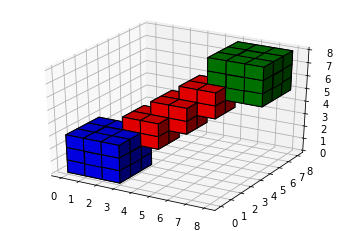

In [13]:
import numpy as np


# prepare some coordinates
x, y, z = np.indices((8, 8, 8))

# draw cuboids in the top left and bottom right corners, and a link between them
cube1 = (x < 3) & (y < 3) & (z < 3)
cube2 = (x >= 5) & (y >= 5) & (z >= 5)
link = abs(x - y) + abs(y - z) + abs(z - x) <= 2

# combine the objects into a single boolean array
voxels = cube1 | cube2 | link

# set the colors of each object
colors = np.empty(voxels.shape, dtype=object)
colors[link] = 'red'
colors[cube1] = 'blue'
colors[cube2] = 'green'

# and plot everything
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(voxels, facecolors=colors, edgecolor='k')

plt.show()

In [29]:
cube1.shape

(8, 8, 8)

In [17]:
ligand.shift_coords()
ligand_voxels = voxelize(ligand)

ValueError: not enough values to unpack (expected 3, got 0)